Having found a prototypical cycle, we now try to shift the timings to
find if there is an improvement.



## Boilerplate



In [1]:
import plot_utils as pu
from hiro_models.one_qubit_model import StocProcTolerances
from hiro_models.otto_cycle import OttoEngine
import hiro_models.model_auxiliary as aux
import numpy as np
import qutip as qt
import utilities as ut
import stocproc
import matplotlib.pyplot as plt
import otto_utilities as ot
import shift_cycle as sc
import ray
import figsaver as fs
ray.shutdown()

#ray.init(address='auto')
ray.init()
from hops.util.logging_setup import logging_setup
import logging
logging_setup(logging.INFO)

## Cycles



Now we need to lay down a grid size.
We start with one dimension and may add another later / dimension.
We shift so that we just overlap with coupling/decoupling and one above.



In [3]:
shifts = sc.make_shifts(extra_r=4)
shifts

array([-0.18, -0.12, -0.06,  0.  ,  0.06,  0.12,  0.18,  0.24,  0.3 ,
        0.36,  0.42])

In [4]:
import itertools
models = [sc.make_model(shift, shift) for shift in shifts]
baseline = models[3]

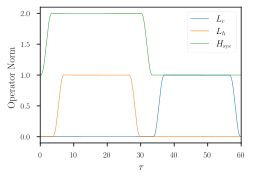

In [5]:
ot.plot_cycle(baseline)
fs.export_fig("cycle_prototype", y_scaling=.7)

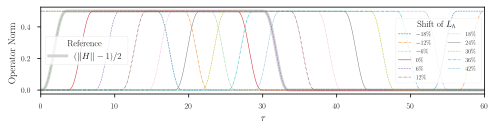

In [6]:
#ot.plot_cycles(models, bath=0, legend=True)
from itertools import cycle
lines = ["--","-.",":", "-"]
linecycler = cycle(lines)

fig, ax = plt.subplots()
t = np.linspace(0, models[0].Θ, 1000)
l, = ax.plot(t, models[0].H.operator_norm(t)/2-.5, linewidth=3, color="lightgrey")
legend_1 = ax.legend([l], [r"$(||H||-1)/2$"], loc="center left", title="Reference")
from cycler import cycler
for model in models:
    ax.plot(t, model.coupling_operators[1].operator_norm(t), label=fr"${model.L_shift[0] * 100:.0f}\%$", linestyle=(next(linecycler)))
ax.legend(title=r"Shift of $L_h$", fontsize="x-small", ncols=2)
ax.set_xlabel(r"$\tau$")
ax.set_ylabel(r"Operator Norm")
ax.add_artist(legend_1)
ax.set_xlim((0, models[0].Θ))
fs.export_fig("cycle_shift_shifts", x_scaling=2, y_scaling=.5)

### Integrate



In [1]:
ot.integrate_online_multi(models, 80_000, increment=10_000, analyze_kwargs=dict(every=10_000))

### Analysis



In [1]:
for model in models:
  print(model.power(steady_idx=1).value / baseline.power(steady_idx=1).value, model.efficiency(steady_idx=1).value)

#+begin_example
  -2.7704455654085876 -2.5219916727767804
  -2.034015641972767 -1.6675487518853185
  0.571544457513159 0.19650010500179352
  1.0 0.30209537308799783
  1.1652434363371367 0.3239348992880912
  1.6254413169874071 0.3309674632505577
  1.6802797038561466 0.3190991034856301
  1.6058539780552505 0.2979616403269744
  1.413212538480568 0.26307105710019735
  0.7332591894799324 0.1434372231954891
  -1.2500012707944386 -0.29523872560546577
#+end_example

In [1]:
ot.plot_energy(baseline)
print(
    fs.tex_value(baseline.system_energy().N,  prefix="N="),
  )

fs.export_fig("prototype_full_energy", x_scaling=2, y_scaling=1)

\(N=80000\)

In [1]:
def thermal_state(T, Ω):
    ρ = np.array([[np.exp(-Ω/T), 0], [0, 1]])
    ρ /= np.sum(np.diag(ρ))

    return ρ
import hops.util.utilities
from hopsflow.util import EnsembleValue
for model in [baseline]:
    with aux.get_data(model) as data:
        trace_dist_c = hops.util.utilities.trace_distance(data, relative_to=thermal_state(model.T[0], model.energy_gaps[0]))
        trace_dist_h = hops.util.utilities.trace_distance(data, relative_to=thermal_state(model.T[1], model.energy_gaps[1]))
        f, (a, aa) = plt.subplots(nrows=1, ncols=2)
        print(thermal_state(model.T[0], model.energy_gaps[0]))
        print(thermal_state(model.T[1], model.energy_gaps[1]))
        pu.plot_with_σ(model.t, EnsembleValue(trace_dist_c), ax=a, label=r"$||\rho(\tau)-\rho_c||$")
        pu.plot_with_σ(model.t, EnsembleValue(trace_dist_h), ax=a, label=r"$||\rho(\tau)-\rho_h||$")
        aa.plot(model.t, data.rho_t_accum.mean[:,0,0].real,  label=r"$\rho_{00}$")
        aa.axhline(thermal_state(model.T[1], model.energy_gaps[1])[0,0],  label=r"$\rho_{h,00}$", color="lightgray")
        aa.axhline(thermal_state(model.T[0], model.energy_gaps[0])[0,0],  label=r"$\rho_{c,00}$", color="lightgray")


        a.set_xlim(2*model.Θ, 3*model.Θ)
        aa.set_xlim(2*model.Θ, 3*model.Θ)
        a.plot(model.t, (model.H(model.t)[:, 0, 0] - 1)/2, label="$H_\mathrm{sys}$ Modulation")
        a.set_xlabel(r"$\tau$")
        aa.set_xlabel(r"$\tau$")
        #a.set_xlim(155)
        a.legend()
        aa.legend()
        aa.set_ylim((0.1,.4))
        fs.export_fig("prototype_thermalization", y_scaling=.7, x_scaling=2)

#+begin_example
  [[0.11920292 0.        ]
   [0.         0.88079708]]
  [[0.37754067 0.        ]
   [0.         0.62245933]]
  /nix/store/08ccd1bg10pbkpv71fwccyxabr1cycim-python3-3.9.15-env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
    return np.asarray(x, float)
  /nix/store/08ccd1bg10pbkpv71fwccyxabr1cycim-python3-3.9.15-env/lib/python3.9/site-packages/matplotlib/axes/_axes.py:5340: ComplexWarning: Casting complex values to real discards the imaginary part
    pts[0] = start
  /nix/store/08ccd1bg10pbkpv71fwccyxabr1cycim-python3-3.9.15-env/lib/python3.9/site-packages/matplotlib/axes/_axes.py:5341: ComplexWarning: Casting complex values to real discards the imaginary part
    pts[N + 1] = end
  /nix/store/08ccd1bg10pbkpv71fwccyxabr1cycim-python3-3.9.15-env/lib/python3.9/site-packages/matplotlib/axes/_axes.py:5344: ComplexWarning: Casting complex values to real discards the imaginary part
  

In [1]:
ot.plot_bloch_components(baseline)
fs.export_fig("state_evolution", y_scaling=.7)

In [1]:
ot.plot_steady_energy_changes([baseline], 2, label_fn=lambda _: "")
fs.export_fig("prototype_energy_change", y_scaling=.7)

In [1]:
ot.plot_power_eff_convergence(models)
fs.export_fig("cycle_shift_convergence", x_scaling=2, y_scaling=.7)

We see that we get a pretty good picture after about 30k-40k samples.



In [1]:
ot.plot_powers_and_efficiencies(np.array(shifts) * 100, models, xlabel="Cycle Shift")
fs.export_fig("cycle_shift_power_efficiency", y_scaling=.7, x_scaling=1)

In [1]:
fig, ax =ot.plot_steady_energy_changes([baseline, models[3+2]], 2, label_fn=lambda m: ("baseline" if m.hexhash == baseline.hexhash else "shifted"))
ax.legend(loc="lower left")
fs.export_fig("shift_energy_change", y_scaling=.7)

The best shift:



In [1]:
best_shift = shifts[3+2]#[np.argmax([-model.power(steady_idx=2).value for model in models])]
best_shift_model = sc.make_model(best_shift, best_shift)

3.5999999999999996

In [1]:
ot.plot_bloch_components(best_shift_model)

| <Figure | size | 340x320 | with | 1 | Axes> | <AxesSubplot: | xlabel= | $\tau$ | > |

In [1]:
t_shift_begin = (2 - best_shift) * baseline.Θ
t_begin = 2 * baseline.Θ
t_shift_end = (3 - best_shift) * baseline.Θ
final_period_idx = np.argmin(abs(baseline.t - t_begin))
final_period_shifted = np.argmin(abs(baseline.t - t_shift_begin))
final_period_shifted_end = final_period_shifted - final_period_idx

t_baseline = baseline.t[final_period_shifted:final_period_shifted_end]
t_final_period = baseline.t[final_period_idx:]
t_plot = baseline.t[: len(t_baseline)]
interaction_change_baseline_cold = (
    baseline.interaction_power()
    .for_bath(0)
    .slice(slice(final_period_shifted, final_period_shifted_end))
    .value
)
interaction_change_best_cold = (
    best_shift_model.interaction_power()
    .for_bath(0)
    .slice(slice(final_period_idx, len(baseline.t)))
    .value
)
interaction_change_baseline_hot = (
    baseline.interaction_power()
    .for_bath(1)
    .slice(slice(final_period_shifted, final_period_shifted_end))
    .value
)
interaction_change_best_hot = (
    best_shift_model.interaction_power()
    .for_bath(1)
    .slice(slice(final_period_idx, len(baseline.t)))
    .value
)


fig, ax = plt.subplots()
ax.plot(t_plot, interaction_change_baseline_cold, label="baseline")
ax.plot(t_plot, interaction_change_best_cold, label="shifted")
ax.plot(t_plot, interaction_change_baseline_hot, linestyle="--", color="C0")
ax.plot(t_plot, interaction_change_best_hot, linestyle="--", color="C1")
ax.legend()
ax.set_xlabel(r"$\tau$")
ax.set_ylabel(r"$P_{\mathrm{int}}$")
fs.export_fig("shift_power", y_scaling=0.7)

In [1]:
ot.plot_energy(baseline)
f, a = ot.plot_energy(best_shift_model)
a.plot(best_shift_model.t, best_shift_model.H(best_shift_model.t)[:, 0,0])

| <matplotlib.lines.Line2D | at | 0x7fe9b1d26c40> |

In [1]:
f, a = plt.subplots()
a.axhline(best_shift_model.system_energy().value[np.argmin(abs(best_shift_model.t - model.Θ * 2))], color="gray", linestyle="--")
r = pu.plot_with_σ(
    best_shift_model.t, best_shift_model.interaction_energy().for_bath(0), ax=a,
    label=r"$\langle H_\mathrm{inter}\rangle$"
)
pu.plot_with_σ(
    best_shift_model.t, best_shift_model.system_energy(), ax=a, label=r"$\langle H_\mathrm{sys}\rangle$"
)
# a.plot(best_shift_model.t, best_shift_model.H(best_shift_model.t)[:, 0,0])
a.plot(
    best_shift_model.t,
    best_shift_model.coupling_operators[0].operator_norm(best_shift_model.t) / 5,
    label="cold bath modulation",
)

# a.plot(
#     best_shift_model.t,
#     best_shift_model.coupling_operators[1].operator_norm(best_shift_model.t) / 5,
#     label="hot bath modulation",
# )
a.plot(
    best_shift_model.t, best_shift_model.system.operator_norm(best_shift_model.t) / 5,
    label="system modulation"
)
# a.plot(best_shift_model.t, best_shift_model.coupling_operators[1].operator_norm(best_shift_model.t) / 5)
a.set_xlim((model.Θ * 2, model.Θ * 2 + 7))

a.set_ylim((-.21, .45))
a.set_xlabel(r"$\tau$")
a.legend(loc="upper right", fontsize="x-small")
fs.export_fig("cold_bath_decoupling", y_scaling=.6)

## Explore Coupling Length Dimension for The best performing state



In [1]:
def overlap(shift_model, N, step, switch_t=3.):
    switch_time = switch_t / T
    (p_H, p_L) = ot.timings(switch_time, switch_time)
    next_model = shift_model.copy()

    #next_model.timings_H=p_H
    next_model.timings_L=p_L

    (a, b, c, d) = next_model.timings_L[0]
    (e, f, g, h) = next_model.timings_L[1]
    next_step = step * N
    (s1, s2) = next_model.L_shift


    next_model.L_shift = (s1 + next_step, s2 - next_step)
    next_model.timings_L = (
        (a - 2 * next_step, b - 2 * next_step, c, d),
        (e, f, g + 2 * next_step, h + 2 * next_step),
    )
    return next_model


def overlap_cold(shift_model, N, step):
    next_model = shift_model.copy()
    (a, b, c, d) = next_model.timings_L[0]
    (e, f, g, h) = next_model.timings_L[1]
    next_step = step * N
    (s1, s2) = next_model.L_shift
    next_model.L_shift = (s1 + next_step, s2 - next_step)
    next_model.timings_L = (
        (a - 2 * next_step, b - 2 * next_step, c - next_step, d - next_step),
        (e + next_step, f + next_step, g + 2 * next_step, h + 2 * next_step),
    )
    return next_model


Ns = list(range(1, 4))[:1]
overlap_models = [overlap(best_shift_model, N, step) for N in Ns]
overlap_models = [overlap_cold(best_shift_model, N, step) for N in Ns]
new_step_size = 6
mini_step = (new_step_size / (N-N_over) / T)
print(mini_step)
overlap_models = [overlap(best_shift_model, N, mini_step, new_step_size) for N in Ns]

# [goto error]
#+begin_example
  ---------------------------------------------------------------------------
  NameError                                 Traceback (most recent call last)
  Cell In[91], line 38
       34     return next_model
       37 Ns = list(range(1, 4))[:1]
  ---> 38 overlap_models = [overlap(best_shift_model, N, step) for N in Ns]
       39 overlap_models = [overlap_cold(best_shift_model, N, step) for N in Ns]
       40 new_step_size = 6

  Cell In[91], line 38, in <listcomp>(.0)
       34     return next_model
       37 Ns = list(range(1, 4))[:1]
  ---> 38 overlap_models = [overlap(best_shift_model, N, step) for N in Ns]
       39 overlap_models = [overlap_cold(best_shift_model, N, step) for N in Ns]
       40 new_step_size = 6

  NameError: name 'step' is not defined
#+end_example

In [1]:
ot.plot_cycles([overlap_models[0]], legend=True)

# [goto error]
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Cell In[90], line 1
----> 1 ot.plot_cycles([overlap_models[0]], legend=True)
:
NameError: name 'overlap_models' is not defined

### Integrate



    all_overlap_models = [best_shift_model, *overlap_models]



In [1]:
ot.integrate_online_multi(overlap_models, 80_000, increment=10_000, analyze_kwargs=dict(every=10_000))

### Analysis



In [1]:
fig, ax = plt.subplots()
t = np.linspace(0, all_overlap_models[0].Θ, 1000)
ax.plot(t, all_overlap_models[0].coupling_operators[0].operator_norm(t), color="C1", linewidth=1, label="Shifted")
ax.plot(t, all_overlap_models[0].coupling_operators[1].operator_norm(t), color="C1", linestyle="--", linewidth=1)
ax.plot(t, all_overlap_models[1].coupling_operators[0].operator_norm(t), color="C2", linewidth=1, label="Shifted with Overlap")
ax.plot(t, all_overlap_models[1].coupling_operators[1].operator_norm(t), color="C2", linestyle="--", linewidth=1)

ax.set_xlabel(r"$\tau$")
ax.set_ylabel(r"$||L_{h/c}||$")
ax.legend()
fs.export_fig("cycle_shift_shift_vs_overlap", y_scaling=.6)
#ot.plot_cycles(all_overlap_models[0:2], legend=True)

In [1]:
ot.plot_power_eff_convergence(all_overlap_models, 2)

| <Figure | size | 340x320 | with | 2 | Axes> | (<AxesSubplot: xlabel= $N$ ylabel= $P$ > <AxesSubplot: xlabel= $N$ ylabel= $\eta$ >) |

In [1]:
f, a= ot.plot_energy(all_overlap_models[-1])
a.plot(model.t, model.coupling_operators[0].operator_norm(model.t))
a.plot(model.t, model.coupling_operators[1].operator_norm(model.t))
a.plot(model.t, model.system.operator_norm(model.t))

| <matplotlib.lines.Line2D | at | 0x7ff2b6947400> |

    [model.power(steady_idx=2).value / best_shift_model.power(steady_idx=2).value for model in all_overlap_models]

    [model.efficiency(steady_idx=2).value / best_shift_model.efficiency(steady_idx=2).value for model in all_overlap_models]

    [model.power(steady_idx=2).N  for model in all_overlap_models]



In [1]:
ot.plot_powers_and_efficiencies([0] + Ns, all_overlap_models)

| <Figure | size | 340x320 | with | 2 | Axes> | <AxesSubplot: | ylabel= | $-\bar{P}$ | > |

In [1]:
f, a = plt.subplots()
a.axhline(0, color="lightgrey")
for model, label in zip(all_overlap_models[:2], ["Shifted", "Shifted with Overlap"]):
    _, _, lines = pu.plot_with_σ(model.t, model.interaction_power().sum_baths().integrate(model.t), ax=a, label=fr"$W_\mathrm{{int}}$ {label}")
    pu.plot_with_σ(model.t, model.system_power().integrate(model.t), ax=a, color=lines[0][0].get_color(), linestyle="--", label=fr"$W_\mathrm{{sys}}$ {label}")
a.set_ylabel(r"$W_{\mathrm{int/sys}}$")
a.set_xlabel(r"$\tau$")
a.legend()
fs.export_fig("cycle_shift_shift_vs_overlap_power", x_scaling=2, y_scaling=.6)

We see that the power boost is solely due to the interaction
modulation.



In [1]:
fig, ax =ot.plot_steady_energy_changes(all_overlap_models, 2, label_fn=(lambda m: ["without overlap", "with overlap"][all_overlap_models.index(m)]))
ax.legend(loc="lower left")

fs.export_fig("overlap_energy_change", y_scaling=.9)

fig, ax =ot.plot_steady_work_baths(all_overlap_models, 2, label_fn=(lambda m: ["without overlap", "with overlap"][all_overlap_models.index(m)]))
ax.legend(loc="lower left")

fs.export_fig("overlap_energy_change_hot_cold", y_scaling=.9)

# [goto error]
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Cell In[206], line 1
----> 1 fig, ax =ot.plot_steady_energy_changes(all_overlap_models, 2, label_fn=(lambda m: ["without overlap", "with overlap"][all_overlap_models.index(m)]))
      2 ax.legend(loc="lower left")
      4 fs.export_fig("overlap_energy_change", y_scaling=.9)
:
NameError: name 'all_overlap_models' is not defined

In [1]:
r = pu.plot_with_σ(all_overlap_models[-1].t, all_overlap_models[-1].interaction_energy().for_bath(0))
# a.plot(all_overlap_models[-1].t, all_overlap_models[-1].H(all_overlap_models[-1].t)[:, 0,0])
r[1].plot(all_overlap_models[-1].t, all_overlap_models[-1].coupling_operators[0].operator_norm(all_overlap_models[-1].t) / 5)
r[1].plot(all_overlap_models[-1].t, all_overlap_models[-1].coupling_operators[1].operator_norm(all_overlap_models[-1].t) / 5)
r[1].set_xlim((model.Θ*2, model.Θ*2+15))

| 120.0 | 135.0 |

### Slower switching



In [1]:
#<<boilerplate>>
shifts = sc.make_shifts(extra_r=4)

#long_models = [sc.make_model(shift, shift, switch_t=6., switch_t_sys=3) for shift in shifts]
long_models = [sc.make_model(shift, shift, switch_t=6.) for shift in shifts]
long_baseline = sc.make_model(0., 0., switch_t=6.)

#+begin_example
  7.199999999999999
  7.199999999999999
  7.199999999999999
  7.199999999999999
  7.199999999999999
  7.199999999999999
  7.199999999999999
  7.199999999999999
  7.199999999999999
  7.199999999999999
  7.199999999999999
  7.199999999999999
#+end_example

In [1]:
fig, ax = plt.subplots()
t = np.linspace(0, models[0].Θ, 1000)
ax.plot(t, models[3].coupling_operators[0].operator_norm(t), color="C1", linewidth=1, label="Fast Switching")
ax.plot(t, models[3].coupling_operators[1].operator_norm(t), color="C1", linestyle="--", linewidth=1)
ax.plot(t, long_models[3].coupling_operators[0].operator_norm(t), color="C2", linewidth=1, label="Slow Switching")
ax.plot(t, long_models[3].coupling_operators[1].operator_norm(t), color="C2", linestyle="--", linewidth=1)

ax.set_xlabel(r"$\tau$")
ax.set_ylabel(r"$||L_{h/c}||$")
ax.legend()
#fs.export_fig("cycle_shift_shift_vs_overlap", y_scaling=.6)
#ot.plot_cycles(all_overlap_models[0:2], legend=True)

#### Analysis



In [1]:
from itertools import cycle
lines = ["--","-.",":", "-"]
linecycler = cycle(lines)

fig, ax = plt.subplots()
t = np.linspace(0, long_models[0].Θ, 1000)
l, = ax.plot(t, long_models[0].H.operator_norm(t)/2-.5, linewidth=3, color="lightgrey")
legend_1 = ax.legend([l], [r"$(||H||-1)/2$"], loc="center left", title="Reference")
from cycler import cycler
for model in [best_shift_model, long_models[5]]:
    ax.plot(t, model.coupling_operators[1].operator_norm(t), label=fr"${model.L_shift[0] * 100:.0f}\%$", linestyle=(next(linecycler)))
    #ax.plot(t, model.coupling_operators[0].operator_norm(t), label=fr"${model.L_shift[0] * 100:.0f}\%$", linestyle=(next(linecycler)))
ax.legend(title=r"Shift of $L_h$", fontsize="x-small", ncols=2)
ax.set_xlabel(r"$\tau$")
ax.set_ylabel(r"Operator Norm")
ax.add_artist(legend_1)
ax.set_xlim((0, long_models[0].Θ))
fs.export_fig("cycle_shift_long_shifts", x_scaling=2, y_scaling=.5)

In [1]:
ot.integrate_online_multi(long_models, 80_000, increment=10_000, analyze_kwargs=dict(every=10_000))

In [1]:
for shift, model in zip(shifts, long_models):
    print(
        shift, best_shift,
        model.power(steady_idx=2).N,
        model.power(steady_idx=2).value / long_baseline.power(steady_idx=2).value,
        (model.efficiency(steady_idx=2).value - long_baseline.efficiency(steady_idx=2).value) * 100,
        (model.efficiency(steady_idx=2).value, long_baseline.efficiency(steady_idx=2).value),
    )

#+begin_example
  -0.18 0.12 80000 -0.7534604455561659 -108.77944601456684 (-0.6547883379568094, 0.4330061221888589)
  -0.12 0.12 80000 0.5591648896822077 -14.974955411404467 (0.28325656807481425, 0.4330061221888589)
  -0.06 0.12 80000 0.9985149794296736 0.0037407432686098474 (0.433043529621545, 0.4330061221888589)
  0.0 0.12 80000 1.0 0.0 (0.4330061221888589, 0.4330061221888589)
  0.06 0.12 80000 0.991206944683175 0.23007686496274715 (0.4353068908384864, 0.4330061221888589)
  0.12 0.12 80000 1.1339755806282883 0.3265587668820624 (0.43627170985767955, 0.4330061221888589)
  0.18 0.12 80000 1.297675283650504 -2.9821368425732797 (0.4031847537631261, 0.4330061221888589)
  0.24 0.12 80000 1.2031272812376834 -7.638926235390614 (0.3566168598349528, 0.4330061221888589)
  0.3 0.12 80000 0.7381994151953918 -20.86521478070438 (0.22435397438181512, 0.4330061221888589)
  0.36 0.12 80000 -0.45819153140116126 -60.284418918547836 (-0.16983806699661946, 0.4330061221888589)
  0.42 0.12 80000 -1.48460840

In [1]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
_, ax1_right = ot.plot_powers_and_efficiencies(np.array(shifts) * 100, models, xlabel="Cycle Shift", ax=ax1)[2]
_, ax2_right = ot.plot_powers_and_efficiencies(np.array(shifts) * 100, long_models, xlabel="Cycle Shift", ax=ax2)[2]

ax1_right.sharey(ax2_right)
ax1.sharey(ax2)

ax1.set_title("Fast Coupling")
ax2.set_title("Slow Coupling")
fs.export_fig("cycle_shift_power_efficiency_with_slower", y_scaling=.7, x_scaling=2)

Aho! The trick is just to slow down the coupling switching.



In [1]:
fig, ax =ot.plot_steady_energy_changes([long_models[3+2], models[3+2]], 2, label_fn=lambda m: ("long" if m.hexhash == long_models[3+2].hexhash else "short"))
ax.legend(loc="lower left")

#fs.export_fig("shift_energy_change", y_scaling=.7)

In [1]:
powers_long = [-model.power(steady_idx=2).value for model in long_models]
powers_short = [-model.power(steady_idx=2).value for model in models]
power_overlap = -overlap_models[0].power(steady_idx=2).value
plt.plot(shifts, powers_short)
plt.plot(shifts, powers_long)
plt.axhline(power_overlap)

# [goto error]
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Cell In[53], line 3
      1 powers_long = [-model.power(steady_idx=2).value for model in long_models]
      2 powers_short = [-model.power(steady_idx=2).value for model in models]
----> 3 power_overlap = -overlap_models[0].power(steady_idx=2).value
      4 plt.plot(shifts, powers_short)
      5 plt.plot(shifts, powers_long)
:
NameError: name 'overlap_models' is not defined

The overlap model still has slightly, but negligible power advantage.



In [1]:
efficiencys_long = [model.efficiency(steady_idx=2).value for model in long_models]
efficiencys_short = [model.efficiency(steady_idx=2).value for model in models]
efficiency_overlap = overlap_models[0].efficiency(steady_idx=2).value
plt.plot(shifts, efficiencys_short)
plt.plot(shifts, efficiencys_long)
plt.axhline(efficiency_overlap)

# [goto error]
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Cell In[28], line 3
      1 efficiencys_long = [model.efficiency(steady_idx=2).value for model in long_models]
      2 efficiencys_short = [model.efficiency(steady_idx=2).value for model in models]
----> 3 efficiency_overlap = overlap_models[0].efficiency(steady_idx=2).value
      4 plt.plot(shifts, efficiencys_short)
      5 plt.plot(shifts, efficiencys_long)
:
NameError: name 'overlap_models' is not defined

Ok, we find that there's nothing special about the overlap model.

Now let's try to find out why the efficiency improved.



In [1]:
best_long_model = long_models[5]

flow_long = -1*best_long_model.bath_energy_flow().for_bath(0)
power_long = best_long_model.interaction_power().for_bath(0)

flow_short = -1*best_shift_model.bath_energy_flow().for_bath(0)
power_short = best_shift_model.interaction_power().for_bath(0)

plt.plot(best_shift_model.t, flow_short.value, label="fast coupling")
plt.plot(best_shift_model.t, flow_long.value, label="slow coupling")
plt.plot(best_shift_model.t, power_short.value, linestyle="--", color="C0")
plt.plot(best_shift_model.t, power_long.value, linestyle="--",  color="C1")
plt.xlim((2*best_long_model.Θ-5, 2*best_long_model.Θ+10))
plt.ylim((-.015,.06))
plt.legend()
plt.xlabel(r"$\tau$")
fs.export_fig("cold_bath_flow", y_scaling=.7)

Way less energy is dumped into the cold bath.



In [1]:
t, rel_short_cold = ot.val_relative_to_steady(
    best_shift_model,
    best_shift_model.bath_energy().for_bath(0),
    2,
    1-best_shift_model.L_shift[0]
)

t, rel_short_hot = ot.val_relative_to_steady(
    best_shift_model,
    best_shift_model.bath_energy().for_bath(1),
    2,
    1-best_shift_model.L_shift[0]
)

t, rel_long_cold = ot.val_relative_to_steady(
    best_long_model,
    best_long_model.bath_energy().for_bath(0),
    2,
    (1-best_long_model.L_shift[0])
)
t, rel_long_hot = ot.val_relative_to_steady(
    best_long_model,
    best_long_model.bath_energy().for_bath(1),
    2,
    (1-best_long_model.L_shift[0])
)
# plt.plot(t, -(rel_long_cold).value, label="slow coupling")
# plt.plot(t, -(rel_long_hot).value, label="slow coupling")
# plt.plot(t, best_long_model.coupling_operators[1].operator_norm(t), label="slow coupling")

plt.plot(t, -(rel_long_cold/rel_long_hot).value, label="slow coupling")
plt.plot(t, -(rel_short_cold/rel_short_hot).value, label="fast coupling")
plt.plot(t, best_long_model.coupling_operators[0].operator_norm(t), color="C0", linestyle="dashed")
plt.plot(t, best_shift_model.coupling_operators[0].operator_norm(t), color="C1", linestyle="dashed")

plt.ylim((-.1,.75))
plt.xlim((100, 128))
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$-\Delta \langle{H_{\mathrm{B},c}}\rangle/\Delta \langle{H_{\mathrm{B},h}}\rangle$")
fs.export_fig("hot_vs_cold_bath", y_scaling=.7)

/home/hiro/src/hopsflow/hopsflow/util.py:331: RuntimeWarning: divide by zero encountered in divide
  left_i[1] / right_i[1],
/home/hiro/src/hopsflow/hopsflow/util.py:331: RuntimeWarning: invalid value encountered in divide
  left_i[1] / right_i[1],
/home/hiro/src/hopsflow/hopsflow/util.py:333: RuntimeWarning: divide by zero encountered in divide
  (left_i[2] / right_i[1]) ** 2
/home/hiro/src/hopsflow/hopsflow/util.py:334: RuntimeWarning: divide by zero encountered in divide
  + (left_i[1] / (right_i[1]) ** 2 * right_i[2]) ** 2
/home/hiro/src/hopsflow/hopsflow/util.py:334: RuntimeWarning: invalid value encountered in divide
  + (left_i[1] / (right_i[1]) ** 2 * right_i[2]) ** 2

In [1]:
plt.plot(best_shift_model.t, (best_shift_model.bath_energy().for_bath(0) / best_shift_model.bath_energy().for_bath(1)).value)
plt.ylim((-1, 1))

/home/hiro/src/hopsflow/hopsflow/util.py:334: RuntimeWarning: invalid value encountered in divide
  (left_i[2] / right_i[1]) ** 2
| -1.0 | 1.0 |

### Slower switching + Only Cold Bath Coupling Shifted



#### Model def and intergration



In [1]:
<<boilerplate>>

In [1]:
shifts = sc.make_shifts(extra_r=4)
cold_models = [sc.make_model(shift, shift, switch_t=6., only_cold=True) for shift in shifts]

In [1]:
ot.integrate_online_multi(cold_models, 1, increment=1, analyze_kwargs=dict(every=10_000))

#+begin_example
  [INFO    hops.core.integration     7496] Choosing the nonlinear integrator.
  [INFO    root                      7496] Starting analysis process.
  [INFO    root                      7496] Started analysis process with pid 16271.
  /home/hiro/src/hops/hops/core/hierarchy_data.py:570: UserWarning: Moving .data/5d118bc5b64eb105ed45c825742f9241f81efa681dc7f6095b7d27ab6b96c284/_6/5d118bc5b64eb105ed45c825742f9241f81efa681dc7f6095b7d27ab6b96c284_6c882ba21738f240daf65b5a8bfeab4b_1.h5 to .data/5d118bc5b64eb105ed45c825742f9241f81efa681dc7f6095b7d27ab6b96c284/_6/5d118bc5b64eb105ed45c825742f9241f81efa681dc7f6095b7d27ab6b96c284_6c882ba21738f240daf65b5a8bfeab4b_1.h5backup_1683647050.4820192 and starting fresh.
    warnings.warn(
  [INFO    hops.core.hierarchy_data  7496] Creating the streaming fifo at: /home/hiro/Documents/Projects/UNI/master/eflow_paper/python/otto_motor/subprojects/cycle_shift/results_5d118bc5b64eb105ed45c825742f9241f81efa681dc7f6095b7d27ab6b96c284.fifo
  [INFO 

    aux.import_results(other_data_path="taurus/.data", other_results_path="taurus/results", models_to_import=cold_models)



#### Cycle showcase



In [1]:
fig, ax = plt.subplots()
t = np.linspace(0, cold_models[0].Θ, 1000)
ax.plot(t, long_models[-3].coupling_operators[0].operator_norm(t), color="C1", linewidth=1, label="both shifted")
ax.plot(t, long_models[-3].coupling_operators[1].operator_norm(t), color="C1", linestyle="--", linewidth=1)
ax.plot(t, cold_models[-3].coupling_operators[0].operator_norm(t), color="C2", linewidth=1, linestyle="dotted", label="only cold shifted")
ax.plot(t, cold_models[-3].coupling_operators[1].operator_norm(t), color="C2", linestyle="--", linewidth=1)
ax.plot(t, (cold_models[-3].system.operator_norm(t)-1)/2, color="lightgrey", linestyle="--", linewidth=1)

ax.set_xlabel(r"$\tau$")
ax.set_ylabel(r"$||L_{h/c}||$")
ax.legend()
fs.export_fig("cycle_shift_cold_shift", y_scaling=.6)
#ot.plot_cycles(all_overlap_models[0:2], legend=True)

In [1]:
from itertools import cycle
lines = ["--","-.",":", "-"]
linecycler = cycle(lines)
fig, ax = plt.subplots()
t = np.linspace(0, models[0].Θ, 1000)
#l, = ax.plot(t, models[0].H.operator_norm(t)/2-.5, linewidth=3, color="lightgrey")
l, = ax.plot(t, cold_models[3].coupling_operators[1].operator_norm(t), linewidth=3, color="lightgrey")
legend_1 = ax.legend([l], [r"$(||H||-1)/2$"], loc="center left", title="Reference")
from cycler import cycler
for model in cold_models:
    ax.plot(t, model.coupling_operators[0].operator_norm(t), label=fr"${model.L_shift[0] * 100:.0f}\%$", linestyle=(next(linecycler)))
ax.legend(title=r"Shift of $L_h$", fontsize="x-small", ncols=2)
ax.set_xlabel(r"$\tau$")
ax.set_ylabel(r"Operator Norm")
ax.add_artist(legend_1)
ax.set_xlim((0, models[0].Θ))

| 0.0 | 60.0 |

In [1]:
fig, (ax2, ax1, ax3) = plt.subplots(nrows=1, ncols=3)
_, ax1_right = ot.plot_powers_and_efficiencies(np.array(shifts) * 100, cold_models, xlabel="Cycle Shift", ax=ax1)[2]
_, ax2_right = ot.plot_powers_and_efficiencies(np.array(shifts) * 100, long_models, xlabel="Cycle Shift", ax=ax2)[2]
_, ax3_right = ot.plot_powers_and_efficiencies(np.array(shifts) * 100, models, xlabel="Cycle Shift", ax=ax3)[2]

ax1_right.sharey(ax2_right)
ax1.sharey(ax2)

ax3_right.sharey(ax1_right)
ax3.sharey(ax1)

ax1.set_title("Cold Shifted")
ax2.set_title("Both Shifted")
fs.export_fig("cycle_shift_power_efficiency_longer_vs_only_cold", y_scaling=.7, x_scaling=2)

In [1]:
ot.plot_multi_powers_and_efficiencies(shifts, [models, long_models, cold_models], ["shifted", "shifted + slower modulation", "slower + only cold shifted"], xlabel=r"Shift $\delta$")
fs.export_fig("shift_comparison", y_scaling=1, x_scaling=2)

### Findings



-   coupling overlap doesn't help much
-   with these parameters the earlier obeservation does not recur
-   more scan needed
-   maybe slower coupling/decoupling will help



## Off-Axis Hamiltonian



In [1]:
<<boilerplate>>

In [1]:
aux.import_results(other_data_path="taurus/.data_oa", other_results_path="taurus/results")

#+begin_example
  [INFO    root                      465451] Not importing 3a88241b44e111869567acbf6ae02285aed02d52bb726b72ac72f9ab31dd3519.
  [WARNING root                      465451] Importing taurus/.data_oa/1ebe2f33ba38ab70dc6af5f72cd5e4163422489db2447d034dcd8d405a0fc79a/_b/1ebe2f33ba38ab70dc6af5f72cd5e4163422489db2447d034dcd8d405a0fc79a_b840f965f993ebd32f9155891c0b1cb4_1.h5 to .data/1ebe2f33ba38ab70dc6af5f72cd5e4163422489db2447d034dcd8d405a0fc79a/_b/1ebe2f33ba38ab70dc6af5f72cd5e4163422489db2447d034dcd8d405a0fc79a_b840f965f993ebd32f9155891c0b1cb4_1.h5.
  [WARNING root                      465451] The model description is 'Classic Cycle'.
  [WARNING root                      465451] Importing taurus/results/flow_1ebe2f33ba38ab70dc6af5f72cd5e4163422489db2447d034dcd8d405a0fc79a.npz to results/flow_1ebe2f33ba38ab70dc6af5f72cd5e4163422489db2447d034dcd8d405a0fc79a_10000.npz.
  [WARNING root                      465451] Importing taurus/results/flow_1ebe2f33ba38ab70dc6af5f72cd5e416342248

In [1]:
off_ax_models = []
weights = [.3, .6]
param_iter = lambda: itertools.product([3, 6], weights)
for switch_t, weight in param_iter():
    off_ax = sc.make_model(0, 0, switch_t=switch_t)
    off_ax.H_0  = 1 / 2 * (qt.sigmaz().full() + np.eye(2) + weight * qt.sigmax().full())
    # NOTE: the hamiltonians will be normalzed so that their smallest EV is 0 and the largest one is 1

    off_ax.H_1  = off_ax.H_0.copy()

    off_ax_models.append(off_ax)

3.5999999999999996
3.5999999999999996
7.199999999999999
7.199999999999999

In [1]:
ot.integrate_online_multi(off_ax_models, 10, increment=10, analyze_kwargs=dict(every=10_000))

In [1]:
for (i, model), weight in zip(enumerate(off_ax_models), weights):
    f, a = ot.plot_bloch_components(model)
    #ot.plot_bloch_components(off_ax_models[i+2], ax=a, linestyle="--", label=None)

    a.set_title(rf"$r_y={weight}$")
    fs.export_fig(f"bloch_expectation_offaxis_{weight}", y_scaling=.7)

In [1]:
np.array(weights) / np.sqrt(1 + np.array(weights) ** 2)

array([0.28734789, 0.51449576])

In [1]:
baselines = [baseline] * 2 + [long_baseline] * 2
for model, ref in zip(off_ax_models, baselines):
    print(model.power(steady_idx=1).value / ref.power(steady_idx=1).value, model.efficiency(steady_idx=1).value / ref.efficiency(steady_idx=1).value)

1.0574121708551179 1.016329556714788
1.1608389370275625 0.9458062530964767
1.039411606725501 0.9835515009556695
1.117040153314062 0.9663817206527843

Interestingly, even with the too-fast switching we have greater power, and greater efficiency.



In [1]:
for (i, model), weight in zip(enumerate(off_ax_models), weights):
    f, a = ot.plot_energy(model)
    a.set_title(rf"$r_y={weight}$")
    fs.export_fig(f"full_energy_offaxis_{weight}", x_scaling=2, y_scaling=1)